# sourcing the data

In [30]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import json 

from utils import load_egraph_data, get_egraph_from_dir, get_dataframes, parse_stop, load_sledge_data, prepare_step_data


data_dir = "../../data/"

egraph_data = get_egraph_from_dir(data_dir)

dataframes = get_dataframes(egraph_data)

egraph = {}

for name, df in dataframes.items():
    if 'alive' in name:
        if 'alive' in egraph:
            egraph['alive'] = pd.concat([egraph['alive'], df])
        else:
            egraph['alive'] = df
    else:
        egraph[name]=df

egraph['alive']

,iterations,stop_reason,egraph_nodes,egraph_classes,memo_size,rebuilds,total_time,search_time,apply_time,rebuild_time,memory,runtime
Select_1100,1,Equivalent,6,5,6,0,0.0,0.0,0.0,0.0,0.35,0.335323
Select_1105,1,Equivalent,6,5,6,0,0.0,0.0,0.0,0.0,0.35,0.332731
muldivrem_152,3,Equivalent,55,31,64,6,0.000086,0.000029,0.000051,0.000005,0.68,0.486089
AddSub_1539_2,3,Equivalent,81,45,86,2,0.000113,0.000034,0.000071,0.000007,0.76,0.563955
muldivrem_290_292,3,Equivalent,65,40,82,12,0.000117,0.000037,0.000071,0.000008,0.84,0.637388
...,...,...,...,...,...,...,...,...,...,...,...,...
InstCombineShift582,4,Saturated,71,46,74,1,0.000277,0.000108,0.000162,0.000006,0.69,0.655284
InstCombineShift279,4,Saturated,79,48,82,1,0.000459,0.000159,0.000289,0.000011,0.78,0.939146
InstCombineShift476,6,Saturated,137,75,159,10,0.000965,0.000332,0.000613,0.00002,1.51,1.513425
InstCombineShift440,11,Timeout,157666,70646,197008,15251,72.536716,72.216971,0.252594,0.067139,6763.69,72860.790439


In [31]:
sledge_raw = {}

data_dir = '../../data/'

for bench in ['rover','alive', 'alive_bitwise']:
    sledge_raw[bench] = pd.DataFrame({
        'lemma':load_sledge_data(f"{data_dir}{bench}/lemma/parsed.json"),
        'no_lemma':load_sledge_data(f"{data_dir}{bench}/no_lemma/parsed.json")
    })

sledge = {}
for test, df in sledge_raw.items():
    if 'alive' in test:
        if 'alive' in sledge:
            sledge['alive'] = pd.concat([sledge['alive'], df])
        else:
            sledge['alive'] = df
    else:
        sledge[name]=df

sledge['alive']

,lemma,no_lemma
AddSub_1614,104.0,11912.0
muldivrem_152,486.0,NaN
Select_1105,259.0,173.0
InstCombineShift497d,NaN,NaN
AddSub_1164,48.0,5881.0
...,...,...
AndOrXor_2515,NaN,18021.0
AndOrXor_1294,NaN,NaN
AndOrXor_2581,NaN,NaN
AndOrXor_2265,NaN,NaN


In [32]:
artifact_dir = '../../../alive_bench/processed_artifact'

toward_data = pd.DataFrame()

for file in os.listdir(artifact_dir):
    name = file.removesuffix('.json')
    print(file, name)
    with open(os.path.join(artifact_dir,file), 'r') as f:
        data = json.load(f)
    
    data = {k.replace(':', '_').replace('-', '_'):v for (k,v) in data.items()}
    
    # using combined since it was the most effective method out of all of them
    new_data = {k: data[k]['combined']['time'] *1000 if data[k]['combined']['status'] == 'unsat' else None for k in data }
    toward_data[name] = new_data

toward_data['num_solved'] = toward_data.apply(lambda x: sum([int(not math.isnan(t)) for t in x]), axis=1)
toward_data = toward_data.where(toward_data['num_solved'] > 0).sort_values(by='num_solved', ascending=True).drop('num_solved', axis=1)
toward_data

cvc4_tplanes.json cvc4_tplanes
cvc4_tplanes_saturate_no_e_matching.json cvc4_tplanes_saturate_no_e_matching
vampire.json vampire
z3_default.json z3_default


,cvc4_tplanes,cvc4_tplanes_saturate_no_e_matching,vampire,z3_default
AndOrXor_298,NaN,50170.0,NaN,NaN
AndOrXor_1864,NaN,8380.0,NaN,NaN
Select_510,NaN,41470.0,NaN,NaN
Select_741,NaN,4380.0,NaN,NaN
muldivrem_290_292,1060.0,NaN,NaN,NaN
...,...,...,...,...
AndOrXor_2243,NaN,NaN,NaN,NaN
AndOrXor_537,NaN,NaN,NaN,NaN
AndOrXor_2429,NaN,NaN,NaN,NaN
AndOrXor_1280,NaN,NaN,NaN,NaN


In [33]:
def plot_cactus(ax, dataframe, timeout = None):
    num_problems = len(dataframe)
    
    ax.axhline(num_problems, label=f'number of problems = {num_problems}', linestyle='dashed', color='blue')
    if timeout:
        ax.axvline(timeout, label=f'Timeout {timeout/1000:.3g} Seconds', linestyle='dashed', color='red')

    for name, values in dataframe.items():
        solved = values.dropna()
        x, y = prepare_step_data(solved.to_list())
        
        if timeout and x[-1] < timeout:
            y.append(y[-1])
            x.append(timeout)
        
        ax.plot(x, y, "-", drawstyle="steps-post", label=f"{name} {len(solved)} ({len(solved)/num_problems:.0%})")

    ax.set_xlabel('Runtime (ms)')
    ax.set_ylabel('Number of solved problems')
    ax.set_xscale('log')
    
def combine_results(x):
    vals_as_list = x.dropna().to_list()
    if vals_as_list != []:
        return min(x.dropna().to_list()) 
    else:
        return None


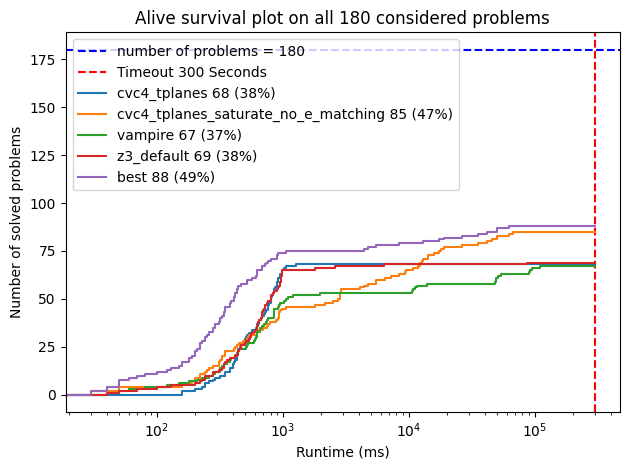

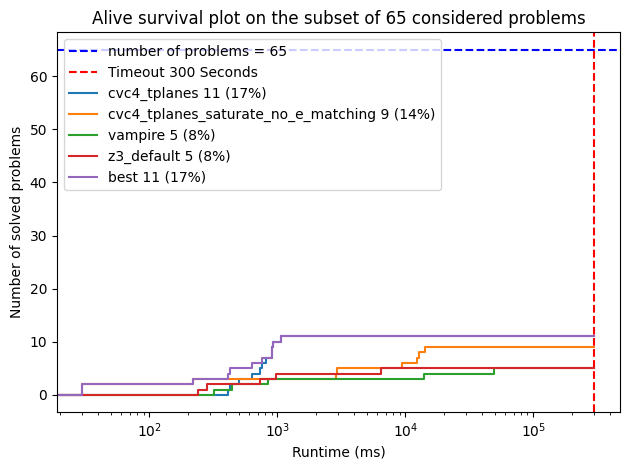

In [34]:
fig, ax = plt.subplots()

toward_data['best'] = toward_data.apply(combine_results, axis=1)

plot_cactus(ax, toward_data, 300000)
ax.legend(loc='upper left')
ax.set_title('Alive survival plot on all 180 considered problems')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

filtered = toward_data.filter(items=sledge['alive'].index.to_list(), axis=0)
 
plot_cactus(ax, filtered,  300000)
ax.legend(loc='upper left')
ax.set_title('Alive survival plot on the subset of 65 considered problems')
plt.tight_layout()
plt.show()

# ROVER

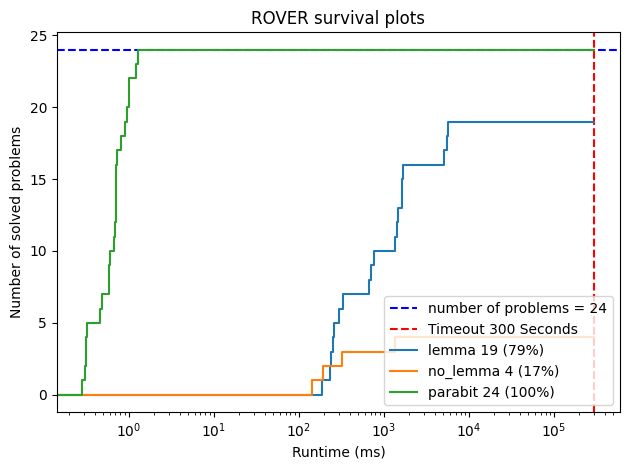

In [35]:

data_comb = sledge['rover'].copy()
data_comb['parabit'] = egraph['rover']['runtime']

fig, ax = plt.subplots()
ax.set_title('ROVER survival plots')
plot_cactus(ax, data_comb, 5*60*1000)
ax.legend()
plt.tight_layout()
plt.show()

# Alive

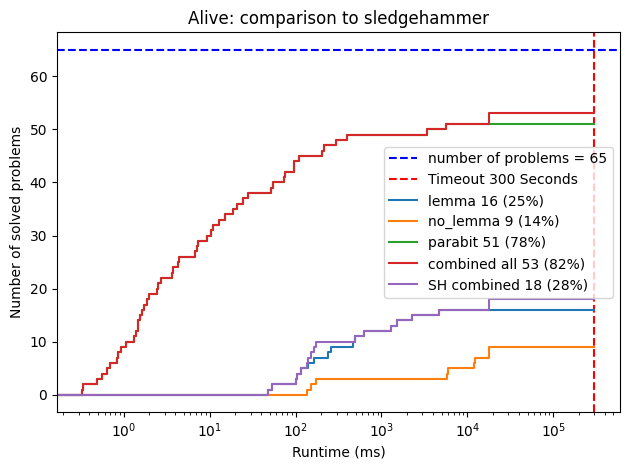

In [36]:
import math

data = sledge['alive'].copy()
data['parabit'] = egraph['alive']['runtime'].where(egraph['alive']['stop_reason'] == 'Equivalent')

data['combined all'] = data.apply(lambda x: min(x.dropna().to_list()) if x.dropna().to_list() != [] else None, axis=1)
data['SH combined'] = data.apply(lambda x: min(x[['lemma', 'no_lemma']].dropna().to_list()) if x[['lemma', 'no_lemma']].dropna().to_list() != [] else None, axis=1)
# data['combine'] = data.apply(lambda x: print(x.dropna().to_list()), axis=1)


fig, ax = plt.subplots()
ax.set_title('Alive: comparison to sledgehammer')

TIMEOUT = 5*60*1000

plot_cactus(ax, data, TIMEOUT)
ax.legend()
plt.tight_layout()
plt.show()



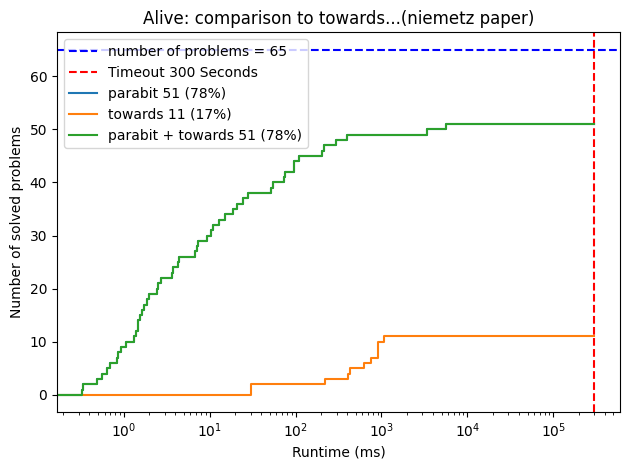

In [37]:
towards_comp = filtered.copy()
towards_comp['parabit'] = egraph['alive']['runtime'].where(egraph['alive']['stop_reason'] == 'Equivalent')

towards_comp['parabit + towards'] = towards_comp[['parabit', 'best']].apply(combine_results, axis=1)


fig, ax = plt.subplots()
ax.set_title('Alive: comparison to towards...(niemetz paper)')

TIMEOUT = 5*60*1000

plot_cactus(ax, towards_comp[['parabit', 'best', 'parabit + towards']].rename(columns={'best':'towards'}), TIMEOUT)
ax.legend()
plt.tight_layout()
plt.show()

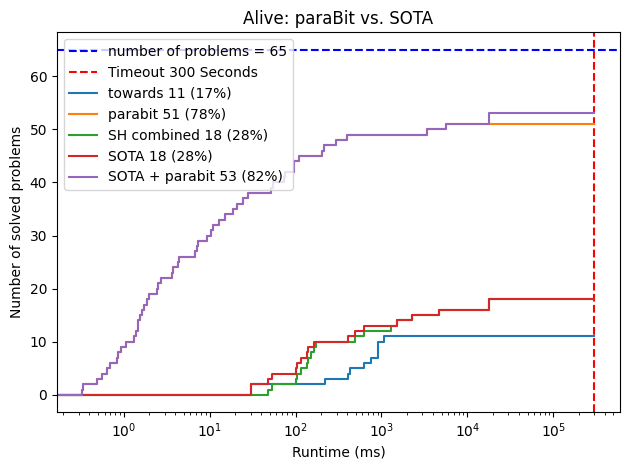

In [45]:
data['towards'] = filtered['best']
data['SOTA'] = data[['towards', 'SH combined']].apply(combine_results, axis=1)
data['SOTA + parabit'] = data[['SOTA', 'parabit']].apply(combine_results, axis=1)


fig, ax = plt.subplots()
ax.set_title('Alive: paraBit vs. SOTA')

TIMEOUT = 5*60*1000

plot_cactus(ax, data[['towards', 'parabit', 'SH combined', 'SOTA', 'SOTA + parabit']], TIMEOUT)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()